In [15]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

In [16]:
images_dir = r"F:\Neural_Network_Steering_Control\source_code\lane_helper\data\20210424_unk_ccw_1"
csv_file = images_dir + ".csv"
df = pd.read_csv(csv_file)

In [17]:
def drawSteerLine(image, angle, color):
    h, w, _ = image.shape
    start_point = (w//2, h)
    if angle == 0:
        end_x = int(w//2 + h//2)
    else:
        end_x = int(w//2 + h//2/math.tan(angle*math.pi/180))
    end_point = (end_x, h//2)

    thickness = 6
    image = cv2.line(image, start_point, end_point, color, thickness)
    return image

In [18]:
def textOnImage(image, pred_angle, cal_angle, v, pos):
    IMAGE_SIZE = (640, 480)
    color_pred_angle = 	(139,0,139)
    color_cal_angle = (210,105,30)
    color_v = (0,100,0)
    color_pos = (0,100,0)

    image = cv2.resize(image, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
    
    #### create transparent rect ###
    x, y, w, h = 320, 0, 640-320, 190
    sub_image = image[y:y+h, x:x+w]
    white_rect = np.ones(sub_image.shape, dtype=np.uint8) * 255

    res = cv2.addWeighted(sub_image, 0.5, white_rect, 0.5, 1.0)

    # Putting the image back to its position
    image[y:y+h, x:x+w] = res
    ################################

    ### add line ###
    image = drawSteerLine(image, int(cal_angle), color_cal_angle)
    image = drawSteerLine(image, int(pred_angle), color_pred_angle)
    ################

    ### add text ###
    text_pred_angle = "pred_angle:"
    text_cal_angle = "des_angle:"
    text_velocity = "v:" + str(df.at[index, "velocity"])
    text_error_pos = "error_pos:" + str(int(df.at[index, "error_pos"]))
    cv2.putText(image, text_pred_angle, (350, 40), cv2.FONT_HERSHEY_COMPLEX, 1, color_pred_angle, 2)
    cv2.putText(image, str(pred_angle), (560, 40), cv2.FONT_HERSHEY_COMPLEX, 1, color_pred_angle, 2)
    cv2.putText(image, text_cal_angle, (350, 80), cv2.FONT_HERSHEY_COMPLEX, 1, color_cal_angle, 2)
    cv2.putText(image, str(cal_angle), (560, 80), cv2.FONT_HERSHEY_COMPLEX, 1, color_cal_angle, 2)
    cv2.putText(image, text_error_pos, (350, 120), cv2.FONT_HERSHEY_COMPLEX, 1, color_pos, 2)
    cv2.putText(image, text_velocity, (350, 160), cv2.FONT_HERSHEY_COMPLEX, 1, color_v, 2)
    ################
    
    return image

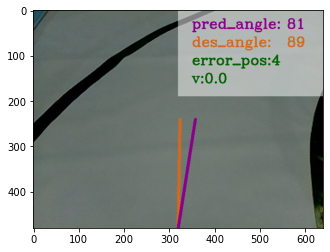

In [19]:
index = 20
image = cv2.imread(images_dir + "/" + df.at[index, "image_name"])
image = textOnImage(image, df.at[index, "predicted_angle"], df.at[index, "desired_angle"], df.at[index, "velocity"], df.at[index, "error_pos"])
plt.imshow(image)

In [20]:
def strTime2ms(str_time):
    str_time = str_time[:-3]
    cum_time = int(str_time[6:])
    cum_time = cum_time + 1000*int(str_time[4:6])
    cum_time = cum_time + 60*1000*int(str_time[2:4])
    cum_time = cum_time + 24*60*1000*int(str_time[0:2])
    return cum_time


In [21]:
IMAGE_SIZE = (640, 480)
video_name = images_dir + ".avi"
video_unit = 1000 #fps
fourcc = cv2.VideoWriter_fourcc(*'XVID') # define the video codec

video = cv2.VideoWriter(video_name, fourcc, video_unit, IMAGE_SIZE)

for index, row in df.iterrows():
    if index == len(df.index)-1:
        break
    time = int(df.at[index, "period"])

    if time <= 0:
        now_filename = df.at[index-1, "image_name"]
        next_filename = df.at[index+1, "image_name"]
        now_time = strTime2ms(now_filename.split("_")[1][:-4])
        next_time = strTime2ms(next_filename.split("_")[1][:-4])
        time = (next_time - int(df.at[index+1, "process_time"])) - (now_time - int(df.at[index-1, "process_time"]))
        image = cv2.imread(images_dir + "/" + df.at[index-1, "image_name"])
        image = textOnImage(image, df.at[index-1, "predicted_angle"], df.at[index-1, "desired_angle"], df.at[index-1, "velocity"], df.at[index-1, "error_pos"])
    else:
        image = cv2.imread(images_dir + "/" + df.at[index, "image_name"])
        image = textOnImage(image, df.at[index, "predicted_angle"], df.at[index, "desired_angle"], df.at[index, "velocity"], df.at[index, "error_pos"])
    
    for _ in range(time):
        video.write(image)

cv2.destroyAllWindows()
video.release()